In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit

# IMPORTANDO A BASE DE DADOS

In [203]:
df = pd.read_csv('DataBase.csv')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,259.994904
1,01 01 2018 00:10,453.769196,5.672167,268.641113
2,01 01 2018 00:20,306.376587,5.216037,272.564789
3,01 01 2018 00:30,419.645905,5.659674,271.258087
4,01 01 2018 00:40,380.650696,5.577941,265.674286


In [204]:
df.rename(columns={
    'LV ActivePower (kW)' : 'Potência',
    'Wind Speed (m/s)'    : 'VelocidadeVento', 
    'Wind Direction (°)'  : 'DireçãoVento'
}, inplace=True)

df.head()

,Date/Time,Potência,VelocidadeVento,DireçãoVento
0,01 01 2018 00:00,380.047791,5.311336,259.994904
1,01 01 2018 00:10,453.769196,5.672167,268.641113
2,01 01 2018 00:20,306.376587,5.216037,272.564789
3,01 01 2018 00:30,419.645905,5.659674,271.258087
4,01 01 2018 00:40,380.650696,5.577941,265.674286


# DISTRIBUIÇÃO DA VARIÁVEL DESEJADA
A variável principal é a potência da turbina, queremos saber os fatores que alteram essa potência com base nos dados. Para isso, precisamos saber como a função se distribui de acordo com sua frequência.

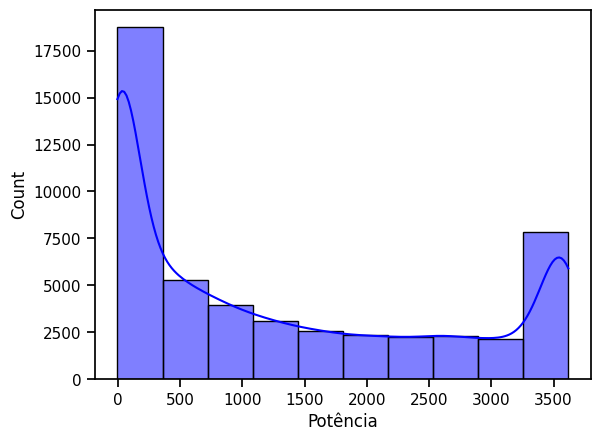

In [205]:
sns.set_context('notebook', font_scale= 1)

ax = sns.histplot(data=df, x='Potência', color='blue', kde=True, bins=10)
plt.show()

Percebe-se que a frequência das potências é bem distribuída, e a função abaixo mostra que 97% dos dados se encontram no intervalo $500 \leq x < 3650$

In [206]:
def prob(data, a, b):
    data   = np.array(data)
    target = 0
    
    for i in range(len(data)):
        if a <= data[i] < b:
            target += data[i]
    
    return target/sum(data)


prob(df['Potência'], 500, 3650)

0.9668051760184065

# COMPORTAMENTO DIREÇÃO X POTÊNCIA
Vamos primeiramente identificar como a potência se comporta em relação à direção do vento, para que se possa encontrar as direções em que há maior potência na turbina. Como todos os dados são contínuos, vamos fazer um scatterplot

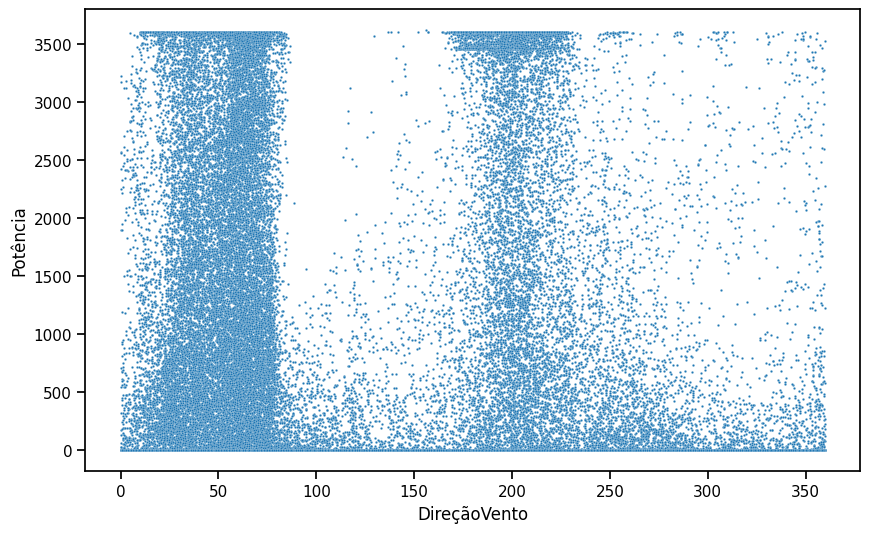

In [207]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['DireçãoVento'], y=df['Potência'], s=3)
plt.show()

Nenhuma relação de função entre as duas variáveis. Mas percebemos que os valores se concentram em 0 a 150 e em 150 a 200, o que mostra que o vento ocorre com mais frequência nessas direções

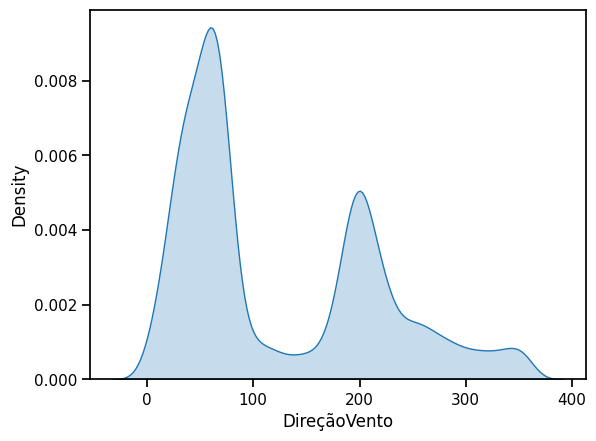

In [208]:
sns.kdeplot(df['DireçãoVento'], fill=True)
plt.show()

Vamos agora encontrar essa frequência de forma mais geral pelos pontos cardeais em um gráfico de pizza

In [209]:
def getDirection(x):
    direções   = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']
    intervalos = [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)] 
    
    for i, direcao in enumerate(direções):
        if intervalos[i][0] < x <= intervalos[i][1]:
            return direcao
    
df['Direção'] = df['DireçãoVento'].apply(getDirection)
df.sample(frac=0.20)

,Date/Time,Potência,VelocidadeVento,DireçãoVento,Direção
20150,25 05 2018 14:50,2308.412109,9.581235,33.403671,NNE
12993,05 04 2018 17:40,0.000000,3.114233,50.275928,ENE
3500,25 01 2018 11:00,0.000000,9.669726,33.145161,NNE
12906,05 04 2018 03:10,0.000000,7.509808,220.637604,SSW
46309,02 12 2018 13:40,0.000000,1.145421,152.593094,SSE
...,...,...,...,...,...
45938,29 11 2018 23:50,3600.374023,16.363630,35.919449,NNE
40618,20 10 2018 07:00,0.000000,2.469519,61.983730,ENE
36307,15 09 2018 18:00,125.216797,4.229813,44.356701,NNE
19301,19 05 2018 17:20,108.366402,4.770492,121.386803,ESE


In [210]:
fig = px.pie(df, values='DireçãoVento', names='Direção', title='Distribuição do Vento')
fig.show()

# RELAÇÃO VELOCIDADE X POTÊNCIA
Vamos agora observar como a potência se comporta com relação à velocidade do vento, como os dados são contínuos, usamos o scatterplot

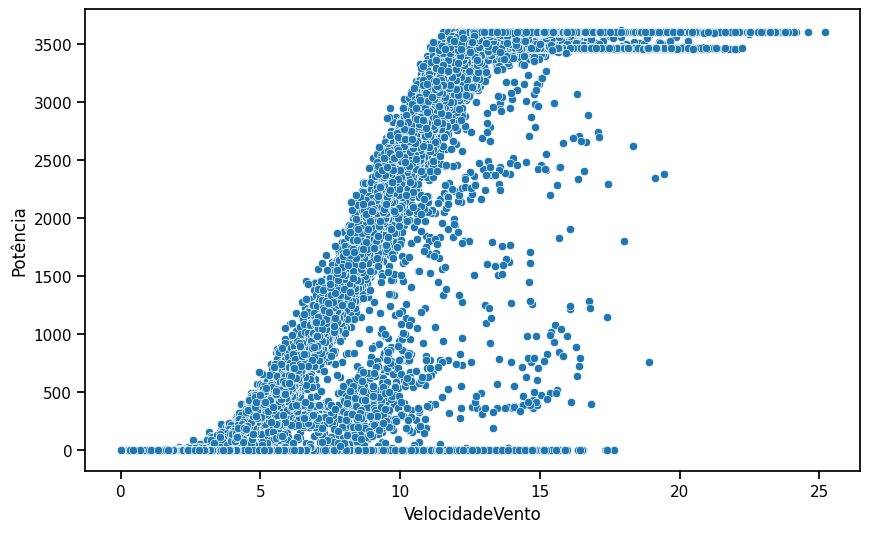

In [211]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['VelocidadeVento'], y=df['Potência'])
plt.show()

Percebemos um padrão de função entre as duas variáveis, mas vamos ter certeza pegando uma pequena amostra dos dados (para diminuir o número de outliers) e diminuir o tamanho dos pontos, pegando apenas 20% dos dados

In [212]:
dfSample = df.sample(frac=0.2)

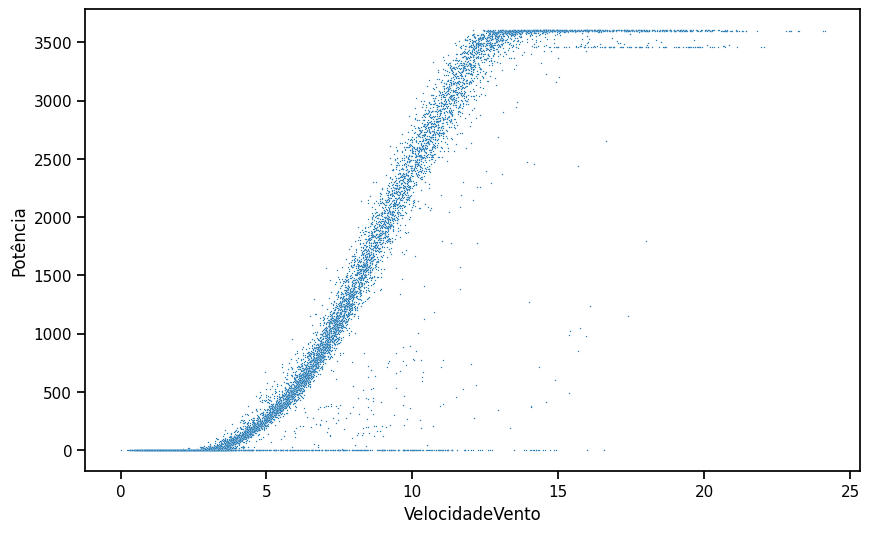

In [213]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dfSample['VelocidadeVento'], y=dfSample['Potência'], s=1)
plt.show()

Percebemos que existe uma relação de função entre as duas variáveis. Vamos encontrá-la por interpolação

### INTERPOLAÇÃO

In [214]:
def funcaoExponencialSuporte(x, Yo, M, k):
        A = (M - Yo) / Yo
        return M / (1 + A * np.e ** (-k * x))

xDados = dfSample['VelocidadeVento'].to_numpy()
yDados = dfSample['Potência'].to_numpy()
    
coeficientes = curve_fit(funcaoExponencialSuporte, xDados, yDados, maxfev=1000000)[0]
xFuncao = np.linspace(min(xDados), max(xDados), 1000)
yFuncao = funcaoExponencialSuporte(xFuncao, *coeficientes)

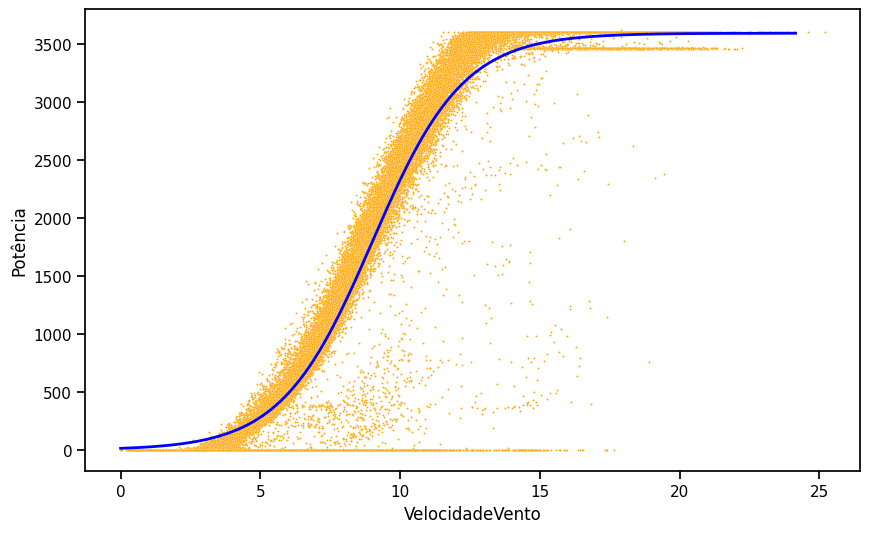

In [215]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=df['VelocidadeVento'], y=df['Potência'], color='orange', s=2)
sns.lineplot(x=xFuncao, y=yFuncao, color='blue', linewidth=2)
plt.show()

### TRATAMENTO DOS DADOS
O intervalo aceitavel de uma potencia $P$ dada uma velocidade $v$ deve ter um intervalo de 20% de máxima extrapolação, ou seja, os dados válidos devem estar no intervalo $P(v) \pm 20\%$

In [216]:
validData   = []
outlierData = []

def getError(velocidade, potencia):
    potenciaMinima = funcaoExponencialSuporte(velocidade, *coeficientes) * 0.8
    potenciaMaxima = funcaoExponencialSuporte(velocidade, *coeficientes) * 1.2
    
    if potenciaMinima < potencia <= potenciaMaxima:
        validData.append(potencia)
    else:
        outlierData.append(potencia)

df.apply(lambda x: getError(x['VelocidadeVento'], x['Potência']), axis=1)
pass

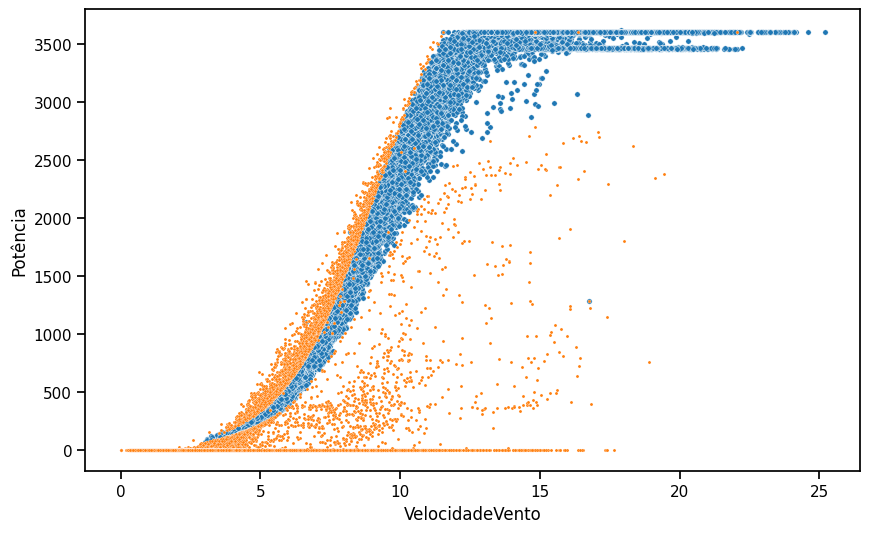

In [217]:
dfValid = df[df['Potência'].isin(validData)]
dfInvalid = df[df['Potência'].isin(outlierData)]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=dfValid['VelocidadeVento'], y=dfValid['Potência'], s=15)
sns.scatterplot(x=dfInvalid['VelocidadeVento'], y=dfInvalid['Potência'], s=5)
plt.show()

In [218]:
invalidos = len(outlierData)/len(df) * 100
print(f'{invalidos:.2f}% dos dados são inválidos')

39.46% dos dados são inválidos
